turn every documents to dictionary with frequency of each term   
    read document   
    count frequency   
    save as a dict   
    count how many documents in collection  

transfer document into tf-idf unit vector    
    create all words vector and sort by alphabetic order  
    count all words tf vector  
    calc idf of each words exists in the collection  
    calc document term frequency by all words vector   
    calc tfidf of each document  
    turn tfidf vector to unit vector  
     
save tf-idf vector as txt file   

write a function, loads the tf-df vectors of documents x and y and returns their cosine similarity    
    input 2 doc id 
    read id txt 
    transfer to vector 
    extend to a sparse vector
    calc cosine similarity  
    return result  

## setup

In [8]:
import numpy as np
import os
from nltk.stem import PorterStemmer
from collections import defaultdict, Counter, OrderedDict
from typing import TypeVar, Generic, Union, List
from math import log
import matplotlib.pyplot as plt
import csv
import re


In [6]:
# variables
DATA_PATH_BASE = "./data/"
OUTPUT_PATH_BASE = "./output/"
T = TypeVar('T')


## tokenization

In [11]:
class TOKENIZE:

    def __init__(self, txt=""):
        '''Initialize all the objects on class instantiation.'''
        self.txt = txt
        self.tokens = []

    def tokenization(self) -> None:
        '''Tokenize tokens in PA1.'''
        valid = ""

        # Save alphabets and space into a new string called valid
        for character in self.txt:
            if character.isalpha() or character.isspace():
                valid += (character)

        # Split the string "valid" by space into list
        self.tokens = valid.split()

    def lowercasing(self) -> None:
        '''Lowercase tokens in PA1.'''

        # For every token inside "tokens", lowercase it
        for idx, token in enumerate(self.tokens):
            self.tokens[idx] = token.lower()

    def steamming_with_porter(self, m=0) -> None:
        '''
        Steamming tokens in PA1 with porter algorithm.
        if words char was not larger then m, then don't stem
        '''

        # Initialzie porter algorithm as "ps"
        ps = PorterStemmer()

        # For every token inside "tokens", use "ps" to stem it
        for idx, token in enumerate(self.tokens):
            s = ps.stem(token)

            # if m is zero, or length after stem is larger then m
            if not m or len(s) > m:
                self.tokens[idx] = s

    def stopword_removal(self) -> None:
        '''Remove all stopwords in tokens in PA1.'''
        clean_tokens = []

        # Declare the stopwords
        STOP_WORDS = ['were', 'shan', 'them', 'i', 'just', 'him', 'below', 'both', "you'd",
                      'don', 'wouldn', "wouldn't", 'then', 's', 'will', 'how', 'wasn', 'am',
                      'should', 'from', 'hasn', 'each', 'any', 'yours', 'who', 'such', 'can',
                      'once', 'on', 'all', 'haven', 'didn', 'again', 'ain', 'doesn', 'same',
                      't', 'and', 'hers', "weren't", 'until', 'has', 'themselves', 'in', 'she',
                      "you've", "couldn't", 'a', 'about', 'been', 'because', 'herself', 'ourselves',
                      'with', 'isn', "didn't", 'mustn', 'needn', 'or', "you're", 'but', 'you',
                      "mightn't", 'of', 'under', 'where', "that'll", 'which', 'does', "hasn't",
                      'have', 'mightn', "hadn't", 'y', 'what', 'won', 'he', 'nor', 'between',
                      'couldn', 'an', 'whom', 'than', 'no', 'd', 'yourself', 'only', 'the', 'this',
                      'after', 'her', "shan't", 'itself', 'being', 'do', 'against', 'into',
                      'me', 'over', "haven't", "don't", 'your', 'now', 'we', 'aren', 'some',
                      'why', 'very', 'shouldn', 'ours', 'doing', 'ma', 'off', 'there', 'himself',
                      "isn't", 'at', 'during', 'had', 'too', 'my', 'before', 'it', 'while', 'most',
                      "doesn't", 'few', 'be', 'hadn', 'those', 'theirs', 'its', 'here', 'll',
                      "you'll", 'myself', 'further', 're', 'their', 'they', "should've", "it's",
                      'by', 'his', 'are', 'yourselves', 'through', 've', 'above', 'o', 'when',
                      'so', "shouldn't", 'out', 'm', "aren't", 'these', 'not', 'weren', 'did',
                      'own', 'if', 'is', 'having', 'as', "mustn't", "won't", 'up', 'our', "she's",
                      'was', 'down', "needn't", 'more', 'that', "wasn't", 'to', 'other', 'for']

        # Append token from "tokens" which does not exist in "STOP_WORDS" into a new list
        for token in self.tokens:
            if token not in STOP_WORDS:
                clean_tokens.append(token)

        # Replace the tokens in PA1 with the one without any stopwords
        self.tokens = clean_tokens

    def save_result(self) -> None:
        '''Save the tokens in PA1 into text file named result.txt.'''

        # Open a textfile and write the tokens into it
        with open("result.txt", "w") as f:
            data = " ".join(self.tokens)
            f.write(data)

    def print_tokens(self, display=False) -> None:
        '''Print tokens in PA1.'''

        # Print the object PA1's tokens
        if display:
            print(self.tokens)

    def tokenize(self, corpus, display, stem_min=0) -> list:
        '''tokenize the corpus'''

        self.txt = corpus
        self.tokenization()  # Tokenization.
        self.lowercasing()  # Lowercasing everything.
        self.stopword_removal()  # Stopword removal.
        # Stemming using Porter’s algorithm.
        self.steamming_with_porter(stem_min)
        self.print_tokens(display)  # Print tokens.
        return self.tokens


In [12]:
class DOCUMENT(Generic[T]):
    def __init__(self, filepath, name, id, display=False, stem_min=0):
        self.TK = TOKENIZE()

        self.filepath = filepath
        self.name = name
        self.id = id
        self.display = display
        self.corpus = self.read_file()  # original words in the docuemnt, string
        self.tokens = self.get_tokens(stem_min)  # tokens of the document, list
        self.tf = self.calc_frequency()  # frequency of each tokens, dict
        self.all_tf_dict = {}  # term frequency in all words, dict
        self.all_tf_list = []  # term frequency list in all words, list, sort in alphabetic
        self.tfidf_unit_vector = []  # the tfidf unit vector of the document, np.ndarray

    def read_file(self) -> str:
        '''read file and turn into corpus(a string)'''

        corpus = ""
        with open(self.filepath) as in_file:
            for line in in_file:
                corpus += line
                corpus += ","
        return corpus

    def get_tokens(self, stem_min=0) -> list:
        '''tokenize the corpus'''

        return self.TK.tokenize(self.corpus, self.display, stem_min)

    def calc_frequency(self) -> dict:
        '''calcualte term frequency in the document'''

        freq = defaultdict(int)
        for token in self.tokens:
            freq[token] += 1
        return freq

    def create_all_words_term_freq(self, all_words_tf_list) -> int:
        '''create term frequency on all words in document'''

        tfd = defaultdict(int)
        for term in all_words_tf_list:
            if term in self.tokens:
                tfd[term] = self.tf[term]
            else:
                tfd[term] = 0

        self.all_tf_dict = tfd

        order_list = self.calc_ordered_freq_list(tfd)
        self.all_tf_list = order_list
        return order_list

    def calc_ordered_freq_list(self, freq_dict) -> list:
        '''create ordered term freq list by dictionary'''

        ordered_list = []
        x = list(sorted(freq_dict.items(),
                 key=lambda item: item[0], reverse=False))  # sort by key

        for i in range(len(x)):
            ordered_list.append(x[i][1])
        return ordered_list

    def calc_tf_idf_unit_vector(self, idf) -> list:
        '''calculate tfidf unit vector base on all words' idf'''

        v = np.array(self.all_tf_list)  # tf
        u = np.array(idf)  # idf
        s = np.multiply(v, u)  # tf*idf
        norm = np.linalg.norm(s)
        unit_vector = s / norm
        self.tfidf_unit_vector = unit_vector
        return unit_vector


## tf-idf

In [9]:

class TF_IDF():
    def __init__(self, /, display=False, stem_min=0) -> None:

        self.display = display  # print result while running
        self.stem_min = stem_min
        self.all_files = []  # list all document file details in the collection
        self.all_documents = []  # all document object in the collection
        self.all_words = []  # the set of words in the collection
        self.df = []  # document frequency of all_words
        self.idf = []  # inverse document frequency of all_words
        self.words_freq_dict = {}  # the key is the word, value is the freq
        self.num_of_documents = 0  # how many documents/files in the collection
        # ordered freq list, [(id, term, freq), ...]
        self.ordered_freq_list = []
        self.cosine_matrix = []  # cosine matrix

    def get_file_from_folder(self, path) -> list:
        '''read all files in the folder's path and save it as a list'''

        listdir = os.listdir(path)
        files = [""] * len(listdir)
        for idx, file_name in enumerate(listdir):
            if file_name[-4:] != ".txt":
                continue
            file_path = os.path.join(path, file_name)
            # the file starts from 1, not zero
            file_num = int(file_name.split(".")[0])
            files[idx] = {"file_path": file_path,
                          "file_name": file_name, "file_num": file_num}

        self.all_files = files
        self.num_of_documents = len(files)
        return files

    def convert_single_document(self, n) -> T:  # n is document id
        '''convert one single file to a DOCUMENT instance'''
        f = 0
        for temp in self.all_files:
            if temp.file_num == n:
                f = temp
                break
        if f == 0:
            print(f"document with ID: {n} doesn't exist")
            return ""
        return DOCUMENT(f['file_path'], f['file_name'], f['file_num'], self.display, self.stem_min)

    def convert_all_document(self) -> list:
        '''convert all files into DOCUMENT instances'''

        documents = []
        for f in self.all_files:
            documents.append(DOCUMENT(
                f['file_path'], f['file_name'], f['file_num'], self.display, self.stem_min))
        self.all_documents = documents
        return self.all_documents

    def calc_idf(self) -> Union[list, list, Counter, list]:
        '''calculate the idf of the dictionary'''

        # add unique tokes into word_list to count document frequency
        word_list = []
        for d in self.all_documents:
            word_list += set(d.tokens)

        # count the term's document frequency and sort the dict
        c = Counter(word_list)
        sorted_c = sorted(c.items(), key=lambda item: item[0], reverse=False)
        counter = OrderedDict(sorted_c)
        self.words_freq_dict = counter

        # create unique word list contains any word exist in the collection
        unique_word_list = list(counter.keys())
        self.all_words = unique_word_list

        # create document frequency list
        df = list(counter.values())
        self.df = df

        # calc idf
        idf = [0] * len(df)
        for idx, doc_freq in enumerate(df):
            idf[idx] = log(self.num_of_documents / doc_freq, 10)
        self.idf = idf

        return unique_word_list, df, counter, idf

    def calc_docuement_tf_idf(self) -> None:
        '''calculate tfidf of each DOCUMENT'''

        for d in self.all_documents:
            d.create_all_words_term_freq(self.all_words)
            d.calc_tf_idf_unit_vector(self.idf)

    def calc_all_cosine_similarity(self) -> List[List[float]]:
        '''calculate the cosine similarity for all pairs of DOCUMENT and save it in a adjacent matrix'''

        n = self.num_of_documents
        cosine_matrix = [[0] * n for i in range(n)]
        for i in range(n):
            for j in range(n):
                #
                if i == j:
                    cosine_matrix[i][j] = 1
                    continue
                if i > j:
                    cosine_matrix[i][j] = cosine_matrix[j][i]
                    continue

                # mutiply two unit vectors
                x = self.all_documents[i].tfidf_unit_vector
                y = self.all_documents[j].tfidf_unit_vector

                cosine_matrix[i][j] = np.inner(x, y)
        self.cosine_matrix = cosine_matrix
        return cosine_matrix

    def get_ordered_freq_list(self) -> list:
        '''convert the dictionary into ordered freqency list'''

        ordered_list = []
        x = list(sorted(self.words_freq_dict.items(),
                 key=lambda item: item[0], reverse=False))

        for i in range(len(x)):
            ordered_list.append(x[i][1])
        self.ordered_freq_list = ordered_list
        return ordered_list

    def save_dictionary(self) -> None:
        '''save the dictionary to dictionary.txt'''

        with open('dictionary.txt', 'w') as f:
            max_len = max(len(l) for l in self.words_freq_dict.keys())
            f.write(f"t_index\t\t{'term'.ljust(max_len+1)}df\n")
            for idx, (word, freq) in enumerate(self.words_freq_dict.items()):
                f.write(f"{idx}\t\t\t{word.ljust(max_len+1)}{freq}\n")

    def save_single_tfidf(self, docid) -> None:
        '''save the tfidf unit vector of the specific DOCUMENT'''

        d = 0
        for temp in self.all_documents:
            if temp.id == docid:
                d = temp
                break
        if d == 0:
            print(f"document with ID: {docid} doesn't exist")
            return ""

        out_filename = f"{OUTPUT_PATH_BASE}{docid}.txt"
        with open(out_filename, 'w') as out_file:
            out_file.write(str(len(d.tf))+'\n')
            out_file.write("t_index tf-idf\n")
            for idx, val in enumerate(d.tfidf_unit_vector):
                if val != 0:
                    out_file.write(f"{idx} {val}\n")

    def save_all_tfidf(self) -> None:
        '''save all tfidf unit vectors'''

        for d in self.all_documents:
            out_filename = f"{OUTPUT_PATH_BASE}{d.id}.txt"
            with open(out_filename, 'w') as out_file:
                out_file.write(str(len(d.tf))+'\n')
                out_file.write("t_index tf-idf\n")
                for idx, val in enumerate(d.tfidf_unit_vector):
                    if val != 0:
                        out_file.write(f"{idx} {val}\n")


def cosine_similarity(docX_ID, docY_ID) -> int:
    '''given two docID, calculate the cosine similarity of two files'''

    x_dict, y_dict = OrderedDict(), OrderedDict()  # initialize

    # read file and turn into dict
    with open(f"{OUTPUT_PATH_BASE}{docX_ID}.txt") as fileX, \
            open(f"{OUTPUT_PATH_BASE}{docY_ID}.txt") as fileY:

        for line in fileX.readlines()[2:]:
            idx, tfidf = line.split()
            x_dict[int(idx)] = float(tfidf)
        for line in fileY.readlines()[2:]:
            idx, tfidf = line.split()
            y_dict[int(idx)] = float(tfidf)

    # get max element
    x_max, y_max = max(list(x_dict.keys())), max(list(y_dict.keys()))
    max_element = int(x_max if x_max > y_max else y_max)
    x, y = np.zeros(max_element), np.zeros(max_element)

    # convert to two list
    for idx, tfidf in x_dict.items():
        x[idx-1] = tfidf
    for idx, tfidf in y_dict.items():
        y[idx-1] = tfidf

    # calculate cosine similarity
    cos_sim = np.inner(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cos_sim


In [13]:
TFIDF = TF_IDF(display=False, stem_min=0)
TFIDF.get_file_from_folder(DATA_PATH_BASE)
TFIDF.convert_all_document()
# TFIDF.save_dictionary()
TFIDF.calc_idf()
TFIDF.calc_docuement_tf_idf()
# TFIDF.save_single_tfidf(1)
# TFIDF.save_single_tfidf(2)
# TFIDF.calc_all_cosine_similarity()
# TFIDF.save_all_tfidf()
# print(cosine_similarity(1, 2))


In [35]:
cos_matrix[0][1]

0.1812483925073165

In [31]:
for i in range(10):
    print(TFIDF.idf[i], sorted(TFIDF.all_words)[i])

3.039414119176137 aan
2.738384123512156 aaron
3.039414119176137 ab
3.039414119176137 aback
3.039414119176137 abahd
1.471212395109142 abandon
3.039414119176137 abat
1.3492180391476234 abc
3.039414119176137 abccom
2.5622928644564746 abcnewscom


In [19]:
f0, f1, f2 = TFIDF.all_files[0], TFIDF.all_files[1], TFIDF.all_files[2]
d0 = DOCUMENT(f0['file_path'], f0['file_name'], f0['file_num'], False)
d1 = DOCUMENT(f1['file_path'], f1['file_name'], f1['file_num'], False)
d2 = DOCUMENT(f2['file_path'], f2['file_name'], f2['file_num'], False)
d0.create_all_words_term_freq(TFIDF.all_words)
d1.create_all_words_term_freq(TFIDF.all_words)
d2.create_all_words_term_freq(TFIDF.all_words)
d0.calc_tf_idf_unit_vector(TFIDF.idf)
d1.calc_tf_idf_unit_vector(TFIDF.idf)
d2.calc_tf_idf_unit_vector(TFIDF.idf)

v = np.array(d1.all_tf_list)  # tf
u = np.array(TFIDF.idf)  # idf
s = np.multiply(v, u)  # tf*idf



In [20]:
np.inner(d0.tfidf_unit_vector, d1.tfidf_unit_vector)

0.11998293486700246

In [21]:
np.inner(d1.tfidf_unit_vector, d2.tfidf_unit_vector)

0.04517336435996829

In [34]:
np.inner(s, d1.tfidf_unit_vector)

19.16488850843764

In [33]:
np.inner(s, d2.tfidf_unit_vector)

0.8657424915098229

## check results

In [21]:
t = all_d[1].all_tf_dict
x = list(sorted(t.items(), key=lambda item: item[0], reverse=False))
for i in range(10):
    print(x[i])


('aan', 0)
('aaron', 0)
('ab', 1)
('aback', 0)
('abahd', 0)
('abandon', 0)
('abat', 0)
('abc', 7)
('abccom', 0)
('abcnewscom', 0)


In [22]:
# print top freq words
x = list(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
for i in range(5):
    print(x[i])

('said', 729)
('us', 604)
('say', 593)
('one', 590)
('state', 570)


In [23]:
tfd = all_d[1].create_all_words_term_freq(TFIDF.all_words).items()

x = list(sorted(tfd, key=lambda item: item[0], reverse=False))
for i in range(10):
    print(x[i])


AttributeError: 'list' object has no attribute 'items'

In [316]:
# print 20 words in freq_dict after some words 
x = list(sorted(freq_dict.items(), key=lambda item: item[0], reverse=False))
for i in range(10):
    print(i, x[i][0], x[i][1])


0 aan 1
1 aaron 3
2 ab 1
3 aback 1
4 abahd 1
5 abandon 37
6 abat 1
7 abc 99
8 abccom 1
9 abcnewscom 3


## compare

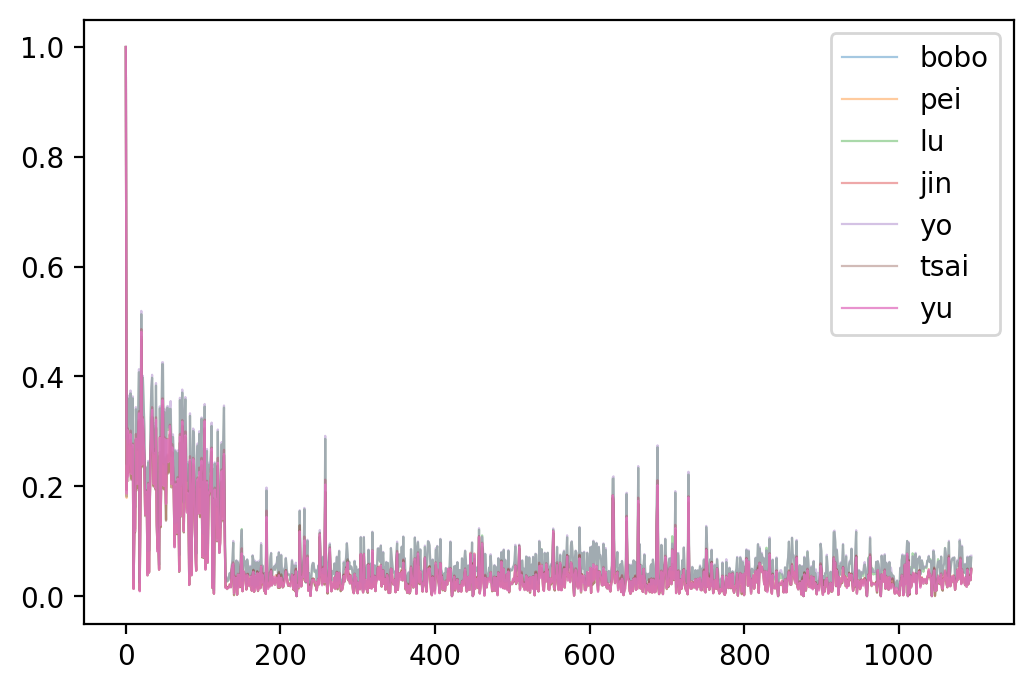

In [53]:
name = ["bobo", "pei", "lu", "jin", "yo", "tsai", "yu"]

# bobo
cos_matrix = TFIDF.calc_all_cosine_similarity()

# peipeipig
in_filename = "others/cosine_1_to_all.txt"
pei_cosine = []
with open(in_filename) as in_file:
    for line in in_file:
        pei_cosine.append(float(line))

# weber lu
in_filename = "others/lu_cos_1_to_all.txt"
lu_cosine = []
with open(in_filename) as in_file:
    for line in in_file:
        lu_cosine.append(float(line))

# jin han
# csv
in_filename = "others/1simi.csv"
jin_cosine = []

with open(in_filename, encoding='utf-8-sig') as handle:
    reader = csv.reader(handle, delimiter='\t')
    for line in reader:
        jin_cosine.append(float(line[0]))

# yo
in_filename = "others/doc1_allcs.txt"
yo_cosine = [1]
with open(in_filename) as in_file:
    for line in in_file:
        yo_cosine.append(float(line.split()[1]))

# tsai
in_filename = 'others/tsai_1.txt'
tsai_cosine = []
with open(in_filename) as in_file:
    for line in in_file:
        tsai_cosine.append(float(line))

# yu huang
in_filename = "others/yu_cos.txt"
yu_cosine = []
with open(in_filename) as in_file:
    str_list = in_file.read()[1:-1].split(", ")
    yu_cosine = [float(x) for x in str_list]

x = np.arange(len(cos_matrix[0]))
plt.figure(dpi=200)
plt.plot(x, cos_matrix[0], alpha=0.4, linewidth=0.8, label=name[0])
plt.plot(x, pei_cosine, alpha=0.4, linewidth=0.8, label=name[1])
plt.plot(x, lu_cosine, alpha=0.4, linewidth=0.8, label=name[2])
plt.plot(x, jin_cosine, alpha=0.4, linewidth=0.8, label=name[3])
plt.plot(x, yo_cosine, alpha=0.4, linewidth=0.8, label=name[4])
plt.plot(x, tsai_cosine, alpha=0.4, linewidth=0.8, label=name[5])
plt.plot(x, yu_cosine, alpha=0.8, linewidth=0.8, label=name[6])
plt.legend()


## PCC

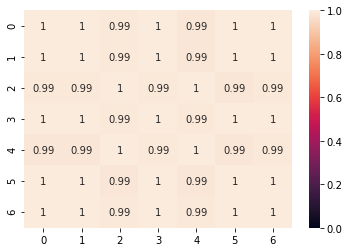

0 bobo
1 pei
2 lu
3 jin
4 yo
5 tsai
6 yu


In [54]:
from scipy.stats import pearsonr
import seaborn as sns
bobo_cosine = cos_matrix[0]
compare_list = [bobo_cosine, pei_cosine, lu_cosine, jin_cosine, yo_cosine, tsai_cosine, yu_cosine]

result = [ [0] * len(compare_list) for x in range(len(compare_list))]

for xi , x in enumerate(compare_list):
    for yi ,y in enumerate(compare_list):
        correlation, p_value = pearsonr(x, y)
        result[xi][yi] = correlation

ax = sns.heatmap(result, annot=True, vmax=1, vmin=0)
# ax.set_yticks(range(0, len(name)), name)
# ax.set_xticks(ticks=range(0, len(name)), label=name)

plt.show()

for idx, n in enumerate(name):
    print(idx, n)